In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.basemap import Basemap
import xarray as xr
import math
import time
from skimage.morphology import binary_erosion
import matplotlib.colors as mcolors
from matplotlib import cm
from collections import deque

import geopy.distance
import os, sys

from Astar_netcdf import AStarPlanner
from rrtstar_netcdf import RRTStar
from rrt_netcdf import RRT

import random

show_animation = False

In [2]:
data = xr.open_dataset('med-hcmr-wav-an-fc-h_1637573239403.nc')  # wave height 22 november
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
time = data.variables['time'][:]
wave = data.variables['VHM0'][:]
mask = data_stat.variables['mask'][0,:,:]
print(data)
print("------------------------------------------------------")
print(mask)

<xarray.Dataset>
Dimensions:    (latitude: 380, time: 24, longitude: 1307)
Coordinates:
  * latitude   (latitude) float32 30.19 30.23 30.27 30.31 ... 45.9 45.94 45.98
  * time       (time) datetime64[ns] 2021-11-22 ... 2021-11-22T23:00:00
  * longitude  (longitude) float32 -18.12 -18.08 -18.04 ... 36.21 36.25 36.29
Data variables:
    VHM0       (time, latitude, longitude) float32 ...
Attributes: (12/15)
    bulletin_type:                   forecast
    institution:                     Hellenic Centre for Marine Research (HCM...
    source:                          MEDWAM3
    credit:                          Copernicus Marine Environment Monitoring...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    producer:                        CMEMS-MED Monitoring and Forecasting Centre
    ...                              ...
    area:                            MED
    bulletin_date:                   2021-11-21 12
    FROM_ORIGINAL_FILE__field_type:  hourly_instanta

In [38]:
lons.values[661]#[661] # 274 660

9.416668

<ipython-input-5-2dbd669b7d7d>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c_scheme = mp.pcolor(x, y, mask, cmap='jet') # wave[0]


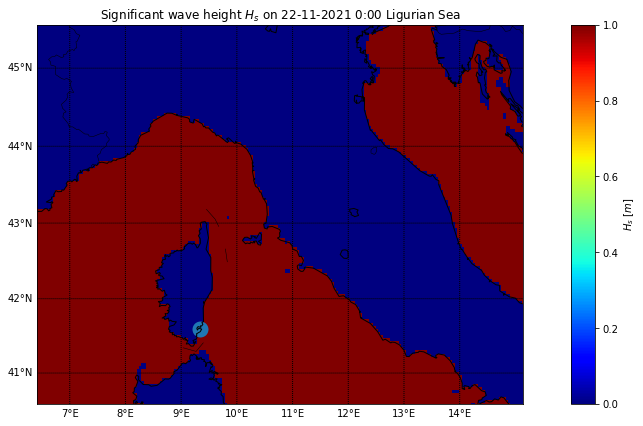

In [5]:
plt.figure(1, figsize=(10, 7))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i')

             
lon, lat = np.meshgrid(lons, lats)
x, y = mp(lon, lat)
x_v, y_v = mp(9.34, 41.6)
c_scheme = mp.pcolor(x, y, mask, cmap='jet') # wave[0]
#mp.fillcontinents(lake_color='aqua')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
mp.scatter(x_v, y_v, marker = 'o', linewidth=10)
mp.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
mp.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes
cbar = mp.colorbar(c_scheme, location='right', pad='10%')
plt.clim(0, 1)
cbar.set_label('$H_s$ $[m]$')

plt.title('Significant wave height $H_s$ on 22-11-2021 0:00 Ligurian Sea')
plt.show()

40.604168

<ipython-input-4-6bede4af1cd6>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, contour_raw_meteo[0], cmap=ListedColormap(['white', 'red']))
<ipython-input-4-6bede4af1cd6>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, contour_raw_meteo[1], cmap=ListedColormap(['white', 'red']))
<ipython-input-4-6bede4af1cd6>:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3

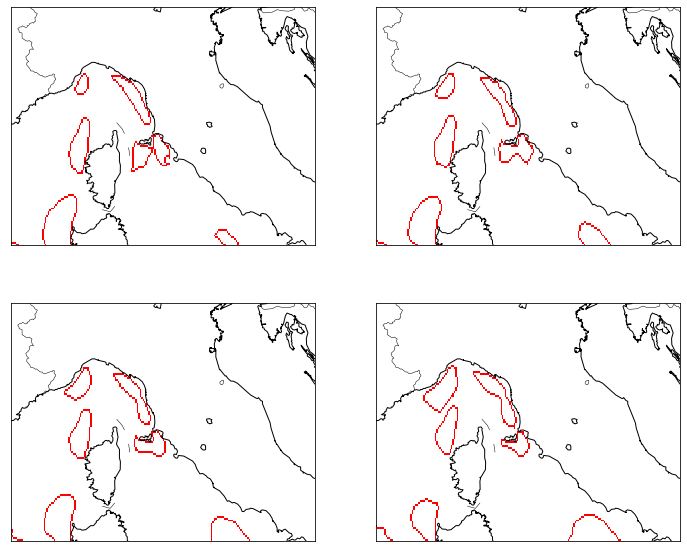

In [4]:
l = 5 
cost = np.zeros_like(wave[:l])
contour_raw_meteo = np.zeros_like(wave[:l])
contour_raw_land = np.logical_xor(mask,binary_erosion(mask)) 
for i in range(l):
    cost[i] = 100 * (np.array(wave[i]) >0.5)
    contour_raw_meteo[i]=np.logical_xor(cost[i],binary_erosion(cost[i]))
    
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58, 
             urcrnrlon=15.13, 
             urcrnrlat=45.5488,  
             resolution='i', ax=ax[0][0])
mp.pcolor(x, y, contour_raw_meteo[0], cmap=ListedColormap(['white', 'red']))
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58, 
             urcrnrlon=15.13,  
             urcrnrlat=45.5488,  
             resolution='i', ax=ax[0][1])
mp.pcolor(x, y, contour_raw_meteo[1], cmap=ListedColormap(['white', 'red']))
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42, 
             llcrnrlat=40.58,  
             urcrnrlon=15.13,  
             urcrnrlat=45.5488,  
             resolution='i', ax=ax[1][0])
mp.pcolor(x, y, contour_raw_meteo[2], cmap=ListedColormap(['white', 'red']))
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,
             llcrnrlat=40.58,  
             urcrnrlon=15.13, 
             urcrnrlat=45.5488,  
             resolution='i', ax=ax[1][1])
mp.pcolor(x, y, contour_raw_meteo[3], cmap=ListedColormap(['white', 'red']))
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

plt.show()

### Area definition

In [ ]:
# rectangular area contour
x_min, y_min = mp(8.958334, 41.354168)    # lons.values[650], lats.values[268]
x_max, y_max = mp(11.500001, 43.270832)   # lons.values[711], lats.values[314]
print("The area of movement is:")
print("x_min = {}, y_min = {}\nx_max = {}, y_max = {}".format(x_min, y_min, x_max, y_max))

sx, sy = mp(9.42857, 43.11295)
gx, gy = mp(11.300001, 42.270832)
print("-------------------------------------------")
print("START is at ({},{}), GOAL is at ({},{})".format(sx, sy, gx, gy))

START is at (334537.5629266633,378168.2533945432), GOAL is at (542631.0977041185,250766.70724292006)


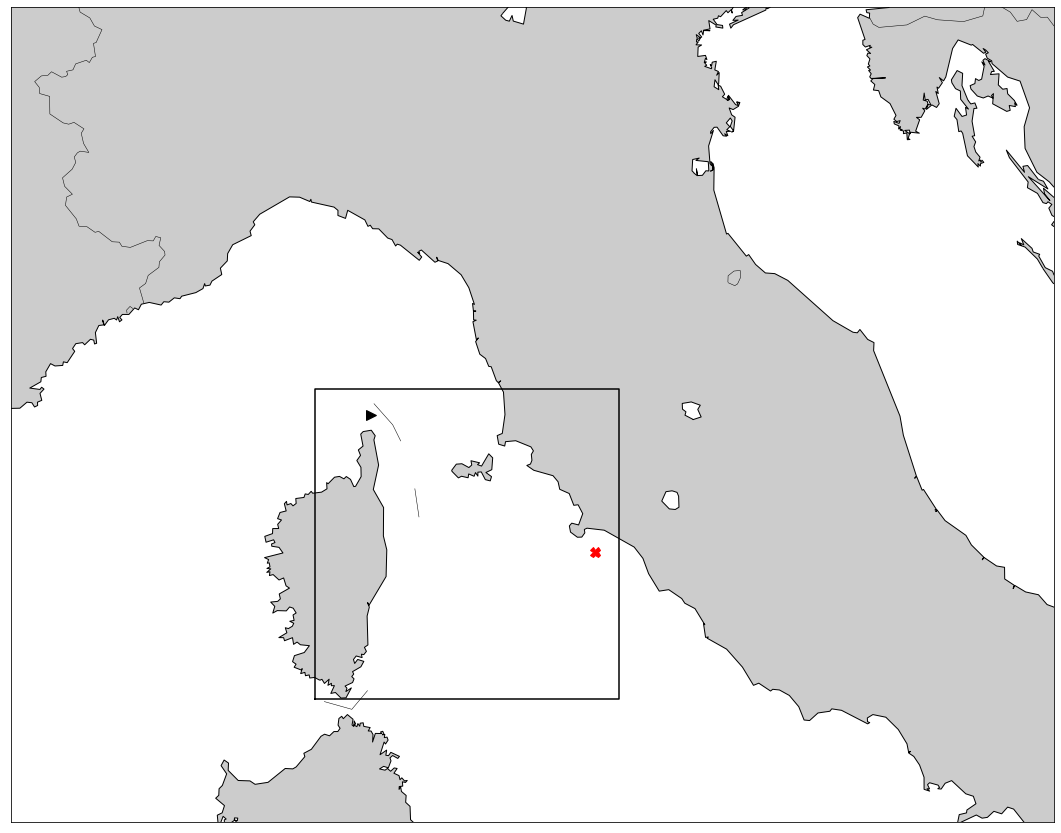

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp = Basemap(projection='merc',
             llcrnrlon=6.42, 
             llcrnrlat=40.58,  
             urcrnrlon=15.13,  
             urcrnrlat=45.5488,  
             resolution='i')
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [11]:
oxland, oyland = [], []
x_obsl, y_obsl = [], []
Cspacex, Cspacey = [], []

oxmeteo, oymeteo = [[] for i in range(l)], [[] for i in range(l)]     # all meteo points
x_obsm, y_obsm = [[] for i in range(l)], [[] for i in range(l)]       # contour meteo points
oxmeteo_, oymeteo_ = [[] for i in range(l)], [[] for i in range(l)]   # all meteo points
x_obsm_, y_obsm_ = [[] for i in range(l)], [[] for i in range(l)]     # contour meteo points

for i in range(l):
    for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons.values[650] <= lons.values[j] <= lons.values[711] and lats.values[268] <= lats.values[k] <= lats.values[314]: 
                if cost[i][k][j] == 100:
                    oxmeteo[i].append(lons.values[j])
                    oymeteo[i].append(lats.values[k])
                if contour_raw_meteo[i][k][j]:
                    x_obsm[i].append(lons.values[j])
                    y_obsm[i].append(lats.values[k])
    oxmeteo_[i], oymeteo_[i] = mp(oxmeteo[i], oymeteo[i])   # meteo points
    x_obsm_[i], y_obsm_[i] = mp(x_obsm[i], y_obsm[i])       # meteo contour points

# land is always static    
for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons.values[650] <= lons.values[j] <= lons.values[711] and lats.values[268] <= lats.values[k] <= lats.values[314]:                      
                if contour_raw_land[k][j]: 
                    x_obsl.append(lons.values[j])
                    y_obsl.append(lats.values[k])
                if mask.values[k][j] == 0:
                    oxland.append(lons.values[j])
                    oyland.append(lats.values[k])
                if mask.values[k][j] == 1:
                    Cspacex.append(lons.values[j])
                    Cspacey.append(lats.values[k])
    
Cspacex_, Cspacey_ = mp(Cspacex, Cspacey)
x_obsl_, y_obsl_ = mp(x_obsl, y_obsl)       # coastline points
oxland_, oyland_ = mp(oxland, oyland)       # land points
# x_obstot_ = x_obsm_ + x_obsl_
# y_obstot_ = y_obsm_ + y_obsl_

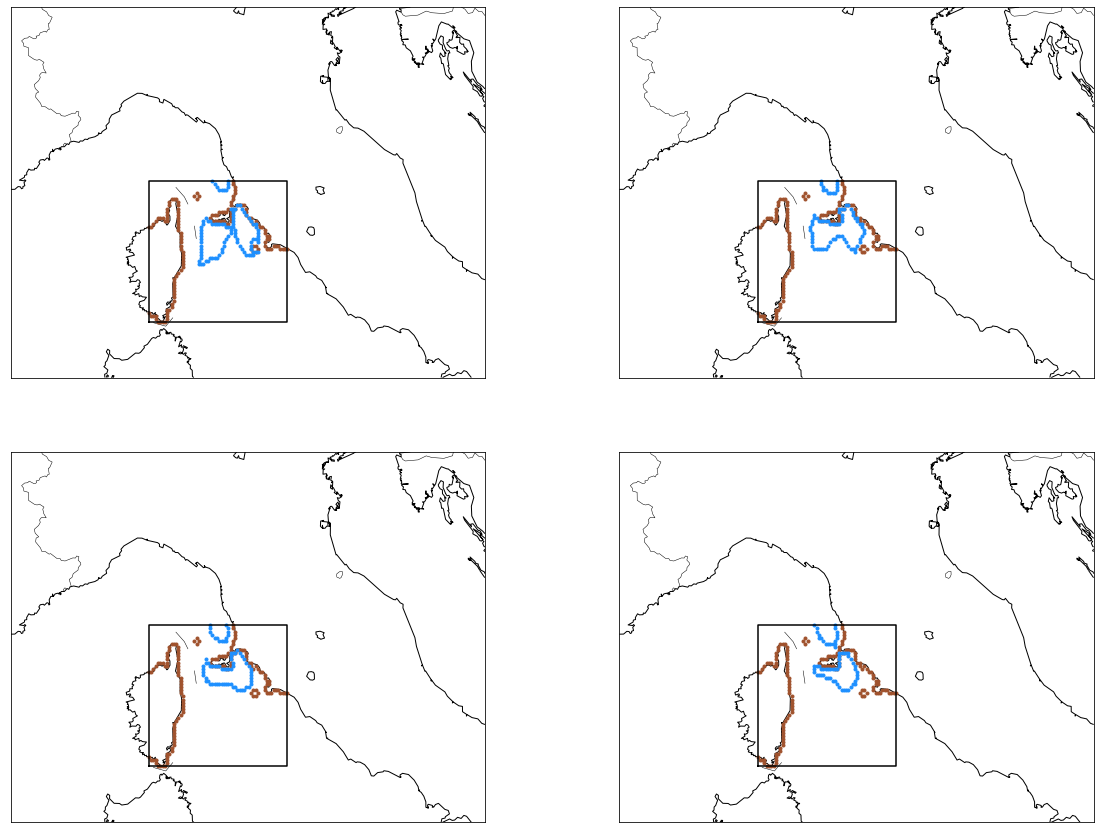

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58, 
             urcrnrlon=15.13, 
             urcrnrlat=45.5488, 
             resolution='i', ax=ax[0][0])
mp.plot(x_obsl_, y_obsl_, '.', color="sienna")
mp.plot(x_obsm_[0], y_obsm_[0], ".", color="dodgerblue")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58,  
             urcrnrlon=15.13,  
             urcrnrlat=45.5488,  
             resolution='i', ax=ax[0][1])
mp.plot(x_obsl_, y_obsl_, '.', color="sienna")
mp.plot(x_obsm_[1], y_obsm_[1], ".", color="dodgerblue")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i', ax=ax[1][0])
mp.plot(x_obsl_, y_obsl_, '.', color="sienna")
mp.plot(x_obsm_[2], y_obsm_[2], ".", color="dodgerblue")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58,  
             urcrnrlon=15.13,  
             urcrnrlat=45.5488,
             resolution='i', ax=ax[1][1])
mp.plot(x_obsl_, y_obsl_, '.', color="sienna")
mp.plot(x_obsm_[3], y_obsm_[3], ".", color="dodgerblue")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

plt.show()

## Path planning

In [20]:
print("Choose the algorithm:\n 1 - APF\n 2 - A*\n 3 - RRT*")
scenario = input('Press a number between 1 and 3 \n')

print("\nAlgorithm " + scenario + " has been pressed")

Choose the algorithm:
 1 - APF
 2 - A*
 3 - RRT*


Press a number between 1 and 3 
 1



Algorithm 1 has been pressed


# APF

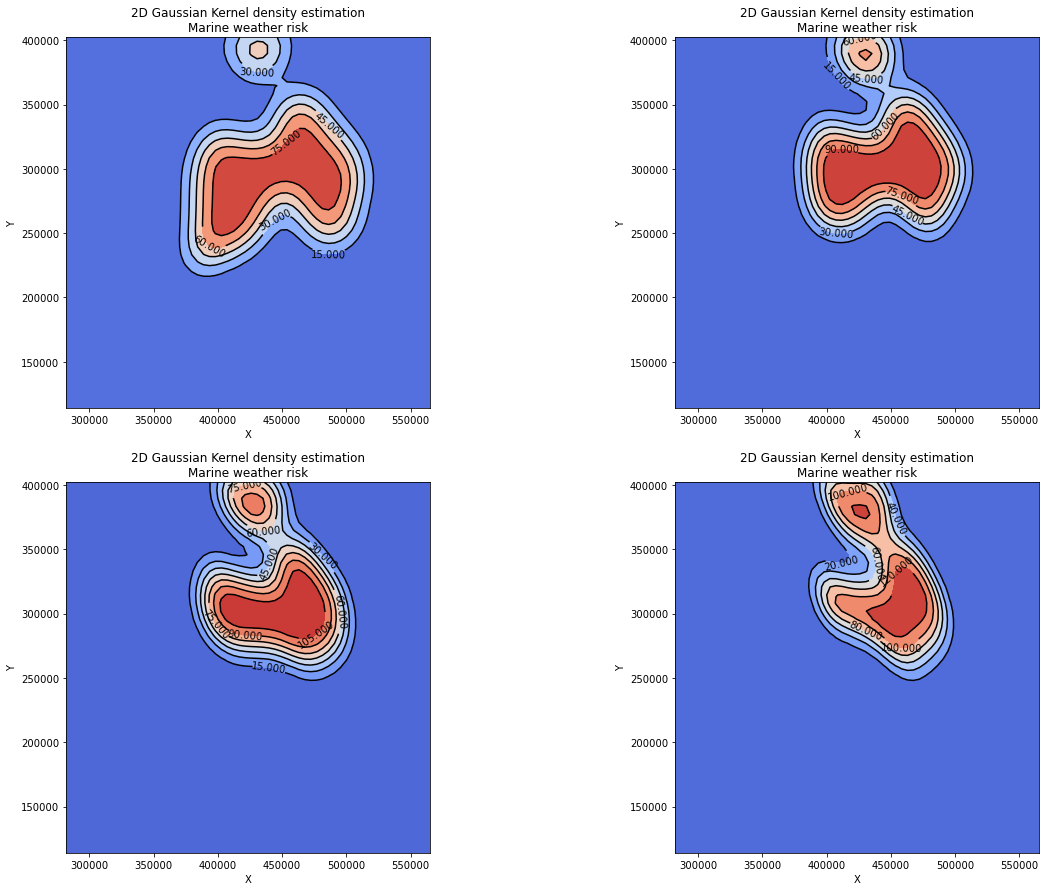

In [34]:
import scipy.stats as st

start = (sx, sy)
goal = (gx, gy)
q_g = 50000
k_att = 1
k_rep_c = 10e9
robot_radius = 10000
ox = x_obsl_
oy = y_obsl_
xw = 62
yw = 47
ux = np.linspace(x_min, x_max, xw)
uy = np.linspace(y_min, y_max, yw)
uxs, uys = np.meshgrid(ux, uy)
f = [[] for i in range(l)]
for i in range(l):
    positions = np.vstack([uxs.ravel(), uys.ravel()])
    values = np.vstack([oxmeteo_[i] + x_obsm_[i], oymeteo_[i] + y_obsm_[i]])
    kernel = st.gaussian_kde(values)
    f[i] = np.reshape(kernel(positions).T, uxs.shape)

f_tot = np.zeros_like(f)
for i in range(l):  
    f_tot[i] = f[i]*10e11
    
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax[0][0].set_xlim(x_min, x_max)
ax[0][0].set_ylim(y_min, y_max)
cfset = ax[0][0].contourf(uxs, uys, f_tot[0], cmap='coolwarm')
ax[0][0].imshow(np.rot90(f_tot[0]), cmap='coolwarm', extent=[x_min, x_max, y_min, y_max])
cset = ax[0][0].contour(uxs, uys, f_tot[0], colors='k')
ax[0][0].clabel(cset, inline=1, fontsize=10)
ax[0][0].set_xlabel('X')
ax[0][0].set_ylabel('Y')
ax[0][0].set_title('2D Gaussian Kernel density estimation\nMarine weather risk')

ax[0][1].set_xlim(x_min, x_max)
ax[0][1].set_ylim(y_min, y_max)
cfset = ax[0][1].contourf(uxs, uys, f_tot[1], cmap='coolwarm')
ax[0][1].imshow(np.rot90(f_tot[1]), cmap='coolwarm', extent=[x_min, x_max, y_min, y_max])
cset = ax[0][1].contour(uxs, uys, f_tot[1], colors='k')
ax[0][1].clabel(cset, inline=1, fontsize=10)
ax[0][1].set_xlabel('X')
ax[0][1].set_ylabel('Y')
ax[0][1].set_title('2D Gaussian Kernel density estimation\nMarine weather risk')

ax[1][0].set_xlim(x_min, x_max)
ax[1][0].set_ylim(y_min, y_max)
cfset = ax[1][0].contourf(uxs, uys, f_tot[2], cmap='coolwarm')
ax[1][0].imshow(np.rot90(f_tot[2]), cmap='coolwarm', extent=[x_min, x_max, y_min, y_max])
cset = ax[1][0].contour(uxs, uys, f_tot[2], colors='k')
ax[1][0].clabel(cset, inline=1, fontsize=10)
ax[1][0].set_xlabel('X')
ax[1][0].set_ylabel('Y')
ax[1][0].set_title('2D Gaussian Kernel density estimation\nMarine weather risk')

ax[1][1].set_xlim(x_min, x_max)
ax[1][1].set_ylim(y_min, y_max)
cfset = ax[1][1].contourf(uxs, uys, f_tot[3], cmap='coolwarm')
ax[1][1].imshow(np.rot90(f_tot[3]), cmap='coolwarm', extent=[x_min, x_max, y_min, y_max])
cset = ax[1][1].contour(uxs, uys, f_tot[3], colors='k')
ax[1][1].clabel(cset, inline=1, fontsize=10)
ax[1][1].set_xlabel('X')
ax[1][1].set_ylabel('Y')
ax[1][1].set_title('2D Gaussian Kernel density estimation\nMarine weather risk')
plt.show()

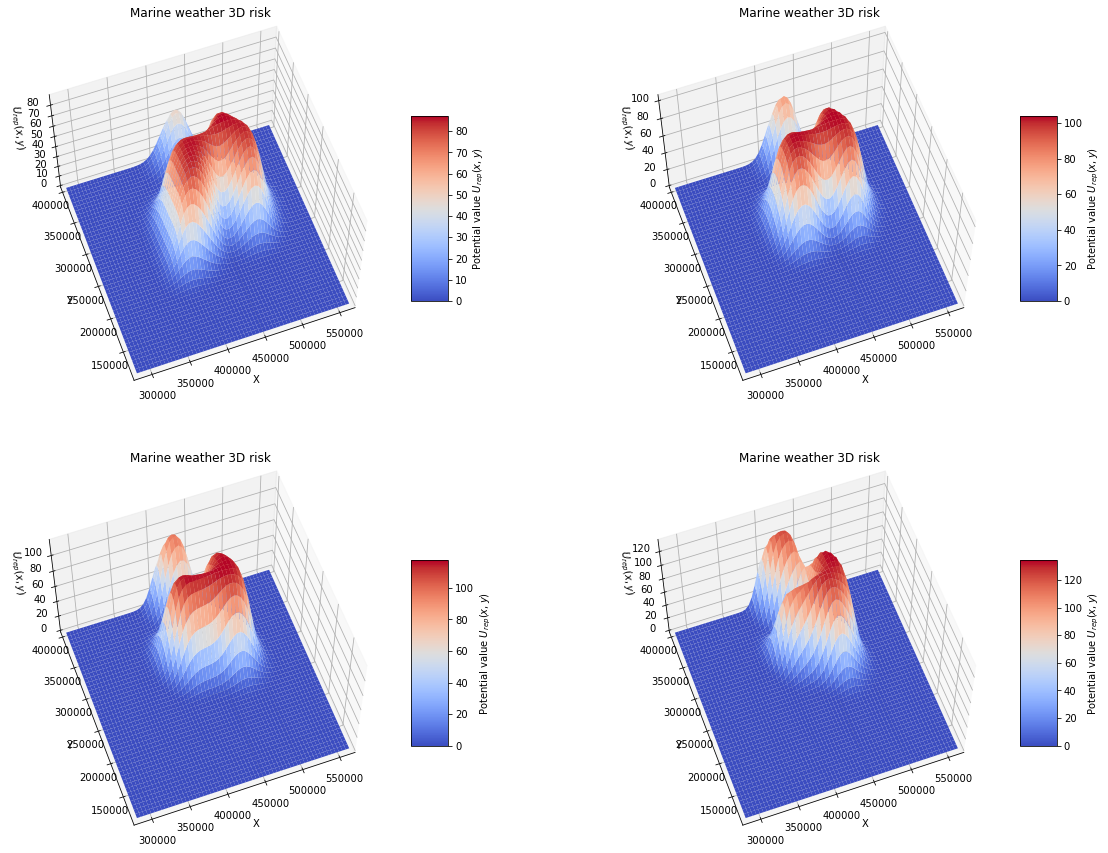

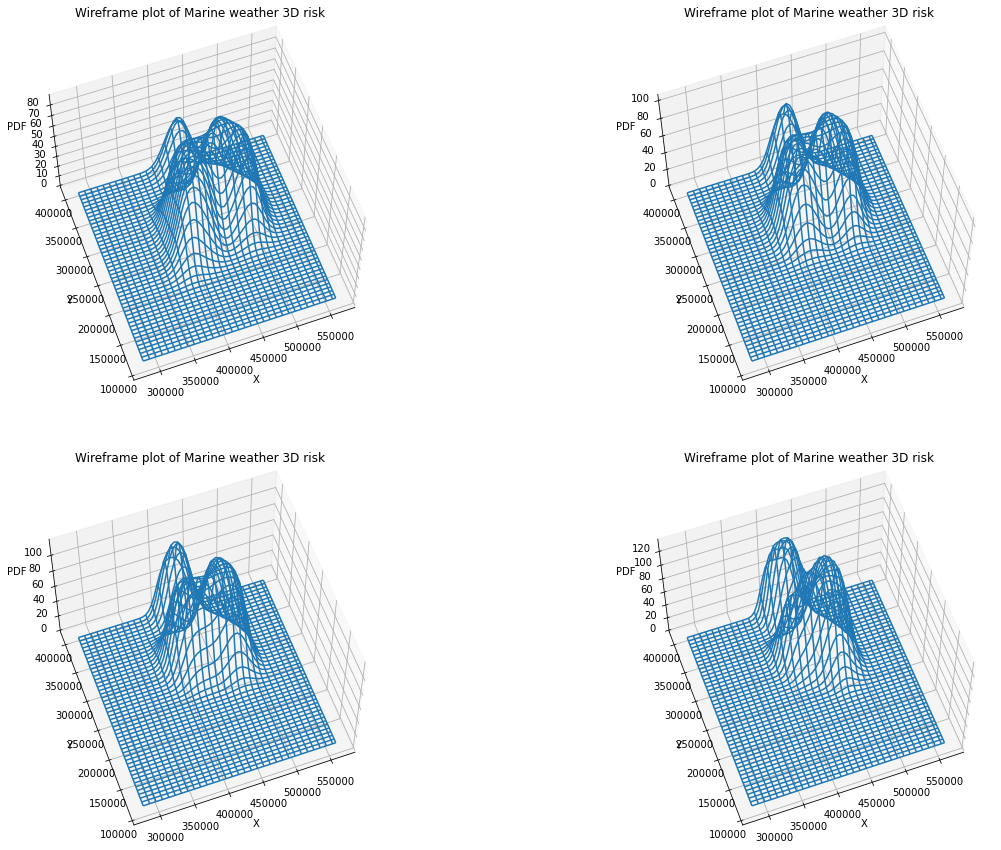

In [27]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(2, 2, 1, projection='3d')
surf = ax.plot_surface(uxs, uys, f_tot[0], rstride=1, cstride=1, cmap='coolwarm')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.colorbar(surf, shrink=0.5, aspect=5, label='Potential value $U_{rep}(x,y)$') # add color bar indicating the PDF
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('$U_{rep}(x,y)$')
ax.set_title('Marine weather 3D risk')

ax = fig.add_subplot(2, 2, 2, projection='3d')
surf = ax.plot_surface(uxs, uys, f_tot[1], rstride=1, cstride=1, cmap='coolwarm')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.colorbar(surf, shrink=0.5, aspect=5, label='Potential value $U_{rep}(x,y)$') # add color bar indicating the PDF
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('$U_{rep}(x,y)$')
ax.set_title('Marine weather 3D risk')

ax = fig.add_subplot(2, 2, 3, projection='3d')
surf = ax.plot_surface(uxs, uys, f_tot[2], rstride=1, cstride=1, cmap='coolwarm')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.colorbar(surf, shrink=0.5, aspect=5, label='Potential value $U_{rep}(x,y)$') # add color bar indicating the PDF
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('$U_{rep}(x,y)$')
ax.set_title('Marine weather 3D risk')

ax = fig.add_subplot(2, 2, 4, projection='3d')
surf = ax.plot_surface(uxs, uys, f_tot[3], rstride=1, cstride=1, cmap='coolwarm')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.colorbar(surf, shrink=0.5, aspect=5, label='Potential value $U_{rep}(x,y)$') # add color bar indicating the PDF
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('$U_{rep}(x,y)$')
ax.set_title('Marine weather 3D risk')
plt.show()

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(2, 2, 1, projection='3d')
w = ax.plot_wireframe(uxs, uys, f_tot[0])
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('PDF')
ax.set_title('Wireframe plot of Marine weather 3D risk')

ax = fig.add_subplot(2, 2, 2, projection='3d')
w = ax.plot_wireframe(uxs, uys, f_tot[1])
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('PDF')
ax.set_title('Wireframe plot of Marine weather 3D risk')

ax = fig.add_subplot(2, 2, 3, projection='3d')
w = ax.plot_wireframe(uxs, uys, f_tot[2])
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('PDF')
ax.set_title('Wireframe plot of Marine weather 3D risk')

ax = fig.add_subplot(2, 2, 4, projection='3d')
w = ax.plot_wireframe(uxs, uys, f_tot[3])
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('PDF')
ax.set_title('Wireframe plot of Marine weather 3D risk')
plt.show()

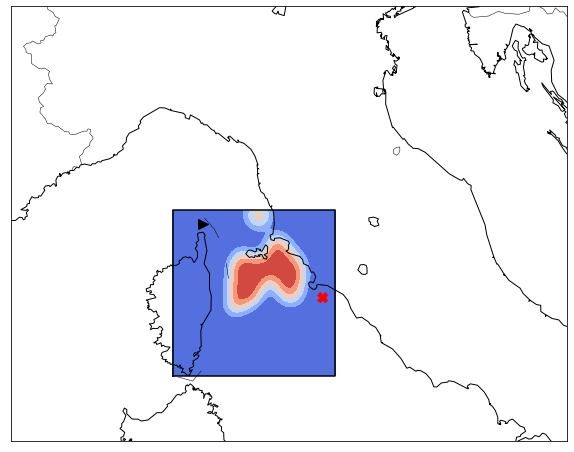

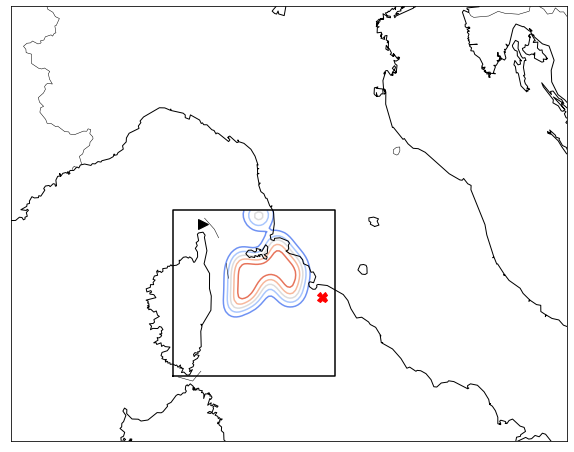

In [29]:
plt.figure(1, figsize=(10, 8))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i')
ax3 = plt.axes()
ax3.contourf(uxs, uys, f_tot[0], cmap='coolwarm')
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

plt.figure(2, figsize=(10, 8))
ax2 = plt.axes()
ax2.contour(uxs, uys, f_tot[0], cmap='coolwarm')
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [36]:
grid_size1 = 4558
grid_size2 = 6133
xw = round((x_max - x_min) / grid_size1)
yw = round((y_max - y_min) / grid_size2)
print("x_width:", xw)
print("y_width:", yw)

# calc each potential
def comb_attractive_potential(x, y, gp, q_g):
    d_g = np.sqrt((x - gp[0]) ** 2 + (y - gp[1]) ** 2)
    if d_g <= 2000:
        d_g = 2000
    if d_g <= q_g:
        att_pot = 0.5 * k_att * d_g ** 2
    else:
        att_pot = q_g * k_att * d_g - 0.5 * k_att * q_g ** 2
    return att_pot

def calc_repulsive_potential(x, y, ox, oy, rr):
    k_rep_c = 10e9
    # search nearest obstacle
    minid = -1
    dmin = float("inf")
    for i, _ in enumerate(ox):
        d = np.hypot(x - ox[i], y - oy[i])
        if dmin >= d:
            dmin = d
            minid = i

    # calc repulsive potential
    dq = np.hypot(x - ox[minid], y - oy[minid])

    if dq <= rr:
        if dq <= 2000:
            dq = 2000

        return 0.5 * k_rep_c * (1.0 / dq - 1.0 / rr) ** 2
    else:
        return 0.0
    
pmap = [[[0.0 for i in range(xw)] for i in range(yw)] for i in range(l)]
for i in range(l):
    for ix in range(xw):
        x = ix * grid_size1 + x_min
        for iy in range(yw):
            y = iy * grid_size2 + y_min
            ug = comb_attractive_potential(x, y, goal, q_g)/5e7
            uo = calc_repulsive_potential(x, y, ox, oy, robot_radius)
            uo_land = calc_repulsive_potential(x, y, x_obsl_, y_obsl_, robot_radius)/10
            uf = ug
            pmap[i][iy][ix] = uf + uo_land
plot_map1 = f_tot + np.array(pmap)

x_width: 62
y_width: 47


<ipython-input-38-608c229bc365>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(uxs, uys, plot_map1[0], cmap=cm.YlOrBr)


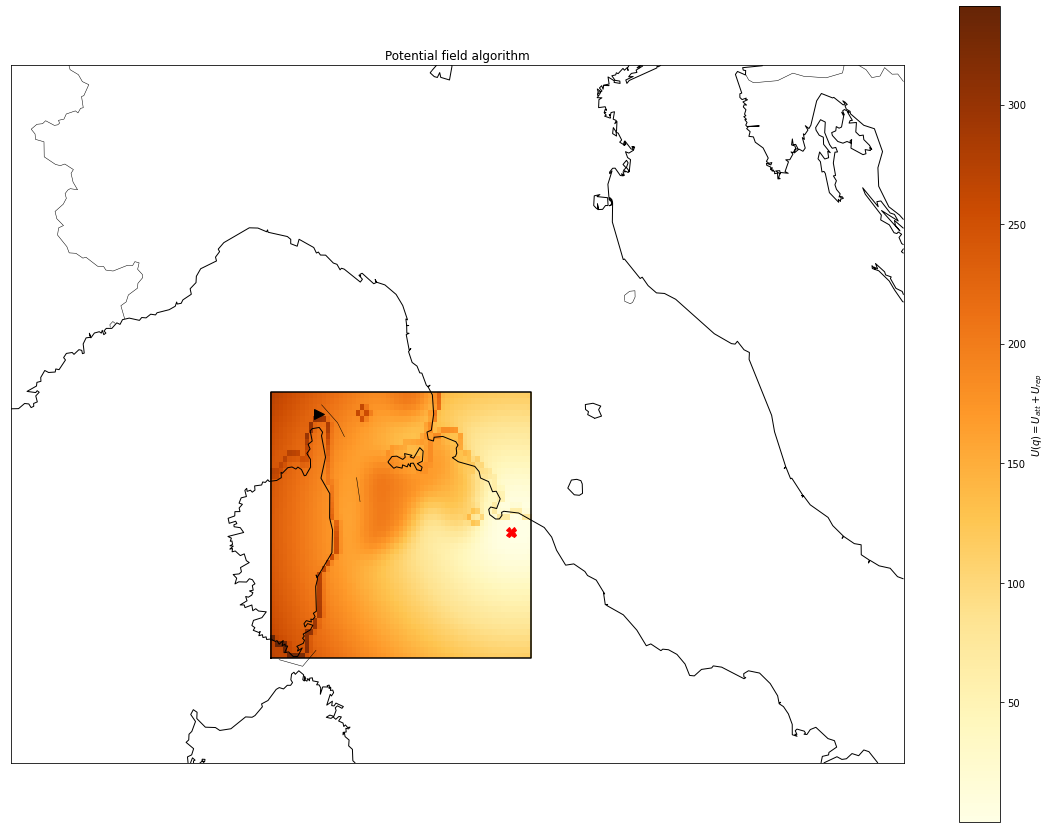

In [38]:
fig1 = plt.figure(1, figsize=(20, 15))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i')
ax = fig1.add_subplot()
plt.pcolor(uxs, uys, plot_map1[0], cmap=cm.YlOrBr)
c_bar = plt.colorbar()
c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
#plt.plot(path_x, path_y, '.k')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.title('Potential field algorithm')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [48]:
OSCILLATIONS_DETECTION_LENGTH = 5

def get_motion_model():
    # dx, dy
    motion = [[1, 0],
              [0, 1],
              [-1, 0],
              [0, -1],
              [-1, -1],
              [-1, 1],
              [1, -1],
              [1, 1]]

    return motion


def oscillations_detection(previous_ids, ix, iy):
    previous_ids.append((ix, iy))

    if (len(previous_ids) > OSCILLATIONS_DETECTION_LENGTH):
        previous_ids.popleft()

    # check if contains any duplicates by copying into a set
    previous_ids_set = set()
    for index in previous_ids:
        if index in previous_ids_set:
            return True
        else:
            previous_ids_set.add(index)
    return False

def rep_potential_detect(os_lim, g, ox, oy, os_r, plot_map, xm, ym, gs1, gs2):
    k_rep_c = 2e8
    for ix in range(62):
        x = ix * gs1 + xm
        for iy in range(47):
            y = iy * gs2 + ym
            dq = np.hypot(x - ox, y - oy)  # distance from the nearest obstacle
            dg = np.hypot(x - g[0], y - g[1])
            if dq <= os_r:
                if dq <= os_lim:
                    dq = os_lim
                plot_map[iy][ix] += 0.5 * k_rep_c * (1 / dq - 1 / os_r) ** 2
            else:
                plot_map[iy][ix] += 0
    return plot_map

def calc_dist_from_start(x, y, start):
    a1 = mp(start[0], start[1], inverse=True)
    b1 = mp(x, y, inverse=True)
    return geopy.distance.distance(a1, b1).m

def potential_field_planning(s, g, reso1, reso2, rr, plot_map, xm, ym, distance, k, xmax, ymax, uxs, uys):
    d = np.hypot(s[0] - g[0], s[1] - g[1])
    ix = round((s[0] - xm) / reso1)
    iy = round((s[1] - ym) / reso2)
    gix = round((g[0] - xm) / reso1)
    giy = round((g[0] - ym) / reso2)

    if show_animation:
        draw_heatmap(plot_map[k-1], uxs, uys)
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
        plt.plot(s[0], s[1], ">k", markersize=5)
        plt.plot(g[0], g[1], "Xr", markersize=5)
        plt.plot([xm, xmax, xmax, xm, xm], [ym, ym, ymax, ymax, ym], "-k")
        mp.drawcoastlines()
        mp.drawstates()
        mp.drawcountries()
        plt.title('Potential field algorithm')
    
    rx, ry = [s[0]], [s[1]]
    motion = get_motion_model()
    previous_ids = deque()

    while d >= 6000:
        minp = float("inf")
        minix, miniy = -1, -1
        for i, _ in enumerate(motion):
            inx = int(ix + motion[i][0])
            iny = int(iy + motion[i][1])
            if iny >= len(plot_map[k-1]) or inx >= len(plot_map[k-1][0]) or inx < 0 or iny < 0:
                p = float("inf")  # outside area
                #print("outside potential!")
            else:
                p = plot_map[k-1][iny][inx]
            if minp > p:
                minp = p
                minix = inx
                miniy = iny
        ix = minix
        iy = miniy
        xp = ix * reso1 + xm
        yp = iy * reso2 + ym
        d = np.hypot(g[0] - xp, g[1] - yp)
        rx.append(xp)
        ry.append(yp)

        if (oscillations_detection(previous_ids, ix, iy)):
            print("Oscillation detected at ({},{})!".format(ix, iy))
            plot_map[k-1] = rep_potential_detect(2000, g, ix*reso1+xm, iy*reso2+ym, 10000, plot_map[k-1], xm, ym, reso1, reso2)
            print(ix*reso1+xm, iy*reso2+ym)
            k = 1
            break

        if show_animation:
            plt.plot(ix*reso1+xm, iy*reso2+ym, ".r")
            plt.pause(0.1)
            
        distance = calc_dist_from_start(xp, yp, s)
        if distance/2 >= 10000*k:
            k += 1
            if k > 4:
                k = 4
            # draw_heatmap(plot_map[k-1], uxs, uys)

    if d < 6000:
        print("The robot is arrived at the final point!")
#     else:
#         print("The robot got lost!"
    return rx, ry, plot_map, d, distance


def draw_heatmap(data, x, y):
    
    data = np.array(data)
    plt.pcolor(x, y, data, cmap=plt.cm.YlOrBr)

In [49]:
d = np.hypot(start[0] - goal[0], start[1] - goal[1])
print("Distance from start to goal is: " + str(d))
plot_map_test = plot_map1
import time
dist_tot = 0
k = 1
start_time = time.time()
while d >= 6000: 
    path_x, path_y, pot_map_sim, d_update, new_distance = potential_field_planning(start, goal, grid_size1, grid_size2, robot_radius, plot_map_test, x_min, y_min, dist_tot, k, x_max, y_max, uxs, uys)
    plot_map_test = pot_map_sim
    d = d_update
print("Computational time is {}".format(time.time() - start_time))

Distance from start to goal is: 243996.05156231544
The robot is arrived at the final point!
Computational time is 0.05339932441711426


<ipython-input-64-7010262bb421>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(uxs, uys, plot_map_test[0], cmap=cm.YlOrBr)


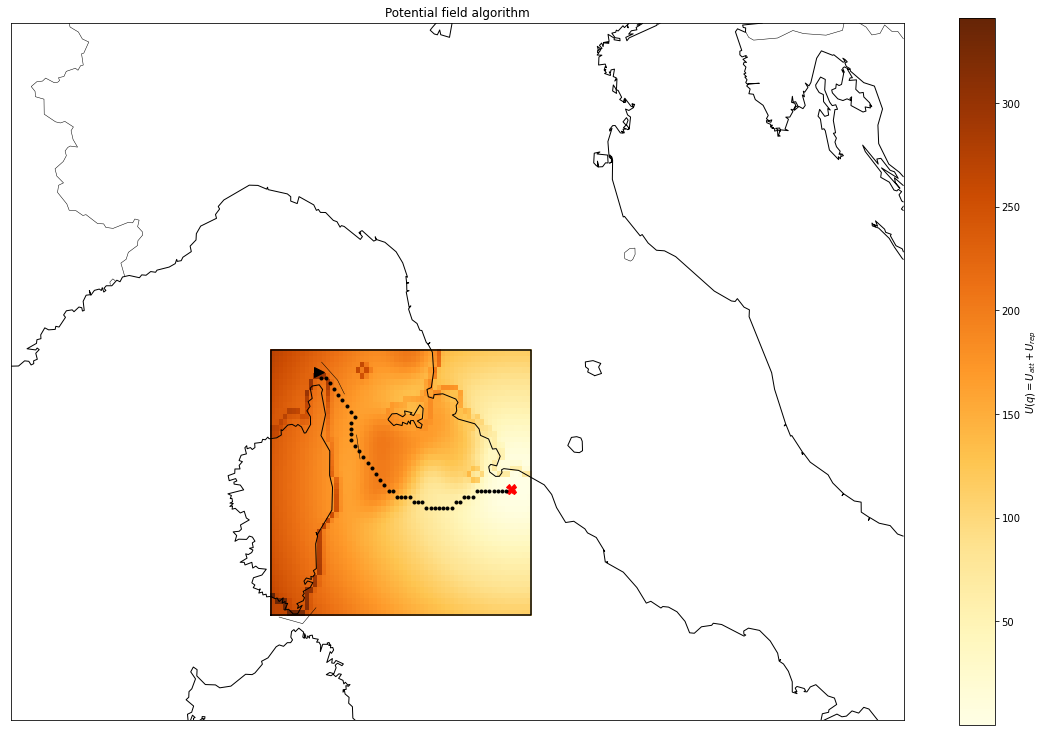

In [64]:
fig1 = plt.figure(1, figsize=(20, 13))
ax = fig1.add_subplot()
plt.pcolor(uxs, uys, plot_map_test[0], cmap=cm.YlOrBr)
c_bar = plt.colorbar()
c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.plot(path_x, path_y, '.k')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.title('Potential field algorithm')
ax.set_aspect('equal', adjustable='box')
plt.show()

# A*

In [93]:
ox_a_list = [[] for i in range(l)]
oy_a_list = [[] for i in range(l)]
for i in range(l):
    for j, _ in enumerate(x_obsm_[i]):
        ox_a_list[i].append(x_obsm_[i][j])
        oy_a_list[i].append(y_obsm_[i][j])
    for k, _ in enumerate(x_obsl_):
        ox_a_list[i].append(x_obsl_[k])
        oy_a_list[i].append(y_obsl_[k])

240

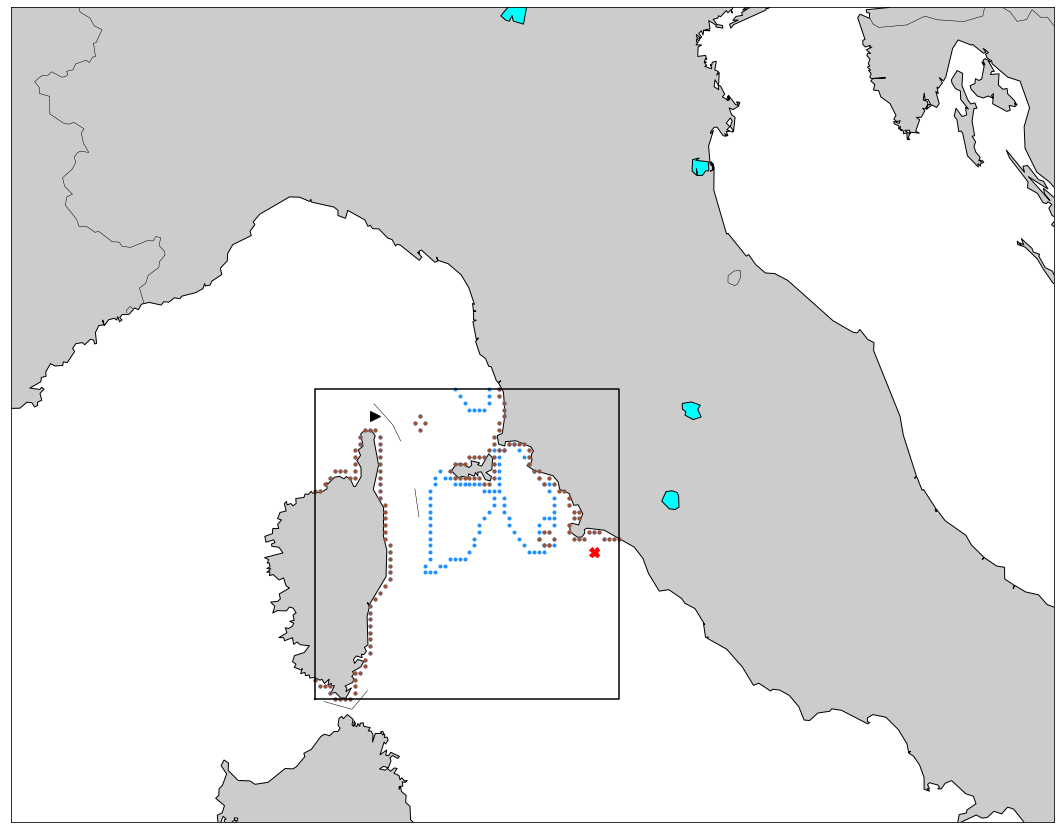

In [70]:
xspace = lons.values[650:712]
yspace = lats.values[268:315]
xs, ys = np.meshgrid(xspace, yspace)
xs_, ys_ = mp(xs, ys)
sx = xspace[12]  # 9.416668
sy = yspace[42]  # 43.104168
gx = xspace[56]   # 11.291668
gy = yspace[22]   # 42.270832

sx_a, sy_a = mp(sx, sy)
gx_a, gy_a = mp(gx, gy)

plt.figure(1, figsize=(20, 15))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58,  
             urcrnrlon=15.13, 
             urcrnrlat=45.5488,  
             resolution='i')
plt.plot(sx_a, sy_a, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot(ox_a_list[0], oy_a_list[0], '.', color="dodgerblue")
plt.plot(x_obsl_, y_obsl_, '.', color="sienna")

plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.fillcontinents(lake_color='aqua')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [89]:
grid_size = 5000
robot_radius = 5000
pot_map3 = [[[0.0 for k in range(len(xspace))] for j in range(len(yspace))] for i in range(l)]                

In [94]:
for i in range(l):
    for ix in range(len(xspace)):
        for iy in range(len(yspace)):
            for q, _ in enumerate(ox_a_list[i]):
                d = math.hypot(ox_a_list[i][q] - xs_[iy][ix], oy_a_list[i][q] - ys_[iy][ix])
                if d <= 5000:
                    pot_map3[i][iy][ix] = True
                    break 

In [97]:
a_star = AStarPlanner(ox_a_list, oy_a_list, grid_size, robot_radius, x_min, y_min, x_max, y_max)
start_time = time.time()
rx_, ry_ = a_star.planning(sx_a, sy_a, gx_a, gy_a)
print("Computational time is {}".format(time.time() - start_time))

min_x: 282249.730022532
min_y: 114007.03369052801
max_x: 564870.0725610546
max_y: 402247.96147155575
x_width: 57
y_width: 58
Find goal
Computational time is 0.08419346809387207


<ipython-input-98-74c054bbee0a>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(xs_, ys_, pmap_astar[0], cmap='coolwarm')
<ipython-input-98-74c054bbee0a>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(xs_, ys_, pmap_astar[1], cmap='coolwarm')
<ipython-input-98-74c054bbee0a>:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilate

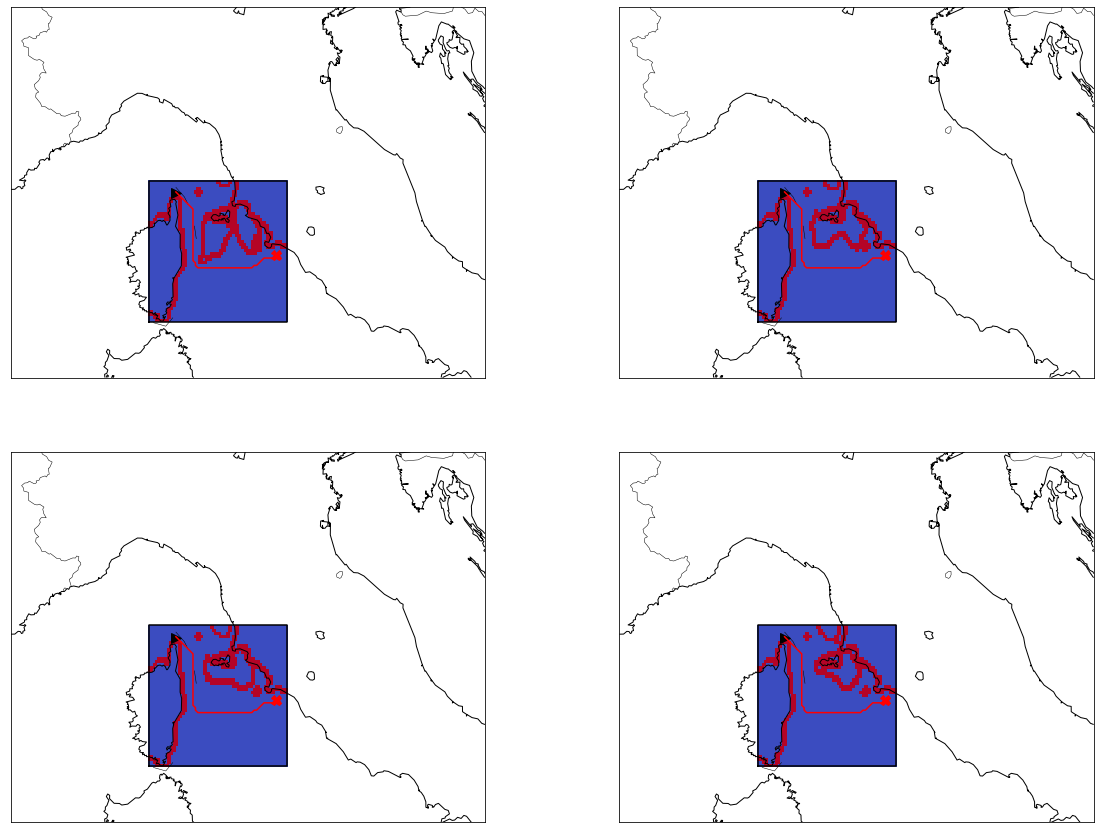

In [98]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
mp = Basemap(projection='merc',
             llcrnrlon=6.42, 
             llcrnrlat=40.58,  
             urcrnrlon=15.13,
             urcrnrlat=45.5488,  
             resolution='i', ax=ax[0][0])
mp.plot(sx_a, sy_a, ">k", markersize=10)
mp.plot(gx_a, gy_a, "Xr", markersize=10)
mp.pcolor(xs_, ys_, pmap_astar[0], cmap='coolwarm')
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.plot(rx_, ry_, '-r')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58,  
             urcrnrlon=15.13,  
             urcrnrlat=45.5488, 
             resolution='i', ax=ax[0][1])
mp.plot(sx_a, sy_a, ">k", markersize=10)
mp.plot(gx_a, gy_a, "Xr", markersize=10)
mp.pcolor(xs_, ys_, pmap_astar[1], cmap='coolwarm')
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.plot(rx_, ry_, '-r')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42, 
             llcrnrlat=40.58, 
             urcrnrlon=15.13, 
             urcrnrlat=45.5488, 
             resolution='i', ax=ax[1][0])
mp.plot(sx_a, sy_a, ">k", markersize=10)
mp.plot(gx_a, gy_a, "Xr", markersize=10)
mp.pcolor(xs_, ys_, pmap_astar[2], cmap='coolwarm')
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.plot(rx_, ry_, '-r')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58, 
             urcrnrlon=15.13,  
             urcrnrlat=45.5488,  
             resolution='i', ax=ax[1][1])
mp.plot(sx_a, sy_a, ">k", markersize=10)
mp.plot(gx_a, gy_a, "Xr", markersize=10)
mp.pcolor(xs_, ys_, pmap_astar[3], cmap='coolwarm')
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.plot(rx_, ry_, '-r')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

plt.show()

# RRT*

In [104]:
sx, sy = mp(9.42857, 43.11295)
gx, gy = mp(11.300001, 42.270832)

obstacle_list = [[] for i in range(l)]

for i in range(l):
    for j, _ in enumerate(x_obsm_[i]):
        obstacle_list[i].append([x_obsm_[i][j], y_obsm_[i][j], 5000])

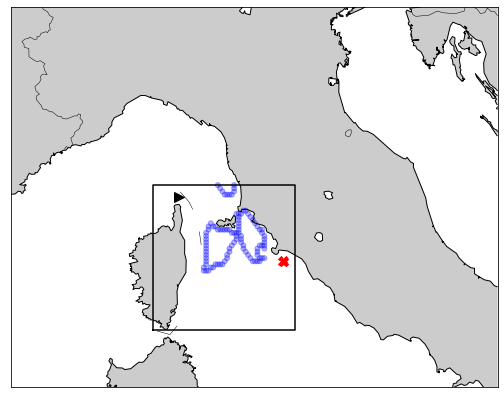

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
mp.fillcontinents()
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
for j in range(len(obstacle_list[0])):
    line = ax.add_patch(plt.Circle(xy=(obstacle_list[0][j][0], obstacle_list[0][j][1]), radius=obstacle_list[0][j][2],
                            color='b', alpha=0.3))
plt.show()

In [106]:
a = (9.45289482921223, 43.08533583676428)
b = (9.42857, 43.112950000000005)
print(geopy.distance.distance(a, b).km)

4.05404252815348


In [39]:
rrt_star = RRTStar(
            start=[sx, sy],
            goal=[gx, gy],
            rand_area=[x_min, x_max, y_min, y_max],
            obstacle_list=obstacle_list,
            c_spacex = Cspacex_,
            c_spacey = Cspacey_,
            speed = 2,
            path_resolution=2500.0,
            connect_circle_dist=100000.0,
            goal_sample_rate=15,
            expand_dis=5000)

NameError: name 'sx' is not defined

In [108]:
start_time = time.time()
path_star, cost_tot, iter_tot = rrt_star.planning(animation=show_animation)
end_time = time.time()
if path_star is None:
    print("Cannot find path")
else:
    print("Found path!!")

print("The computational time is " + str(round(end_time - start_time, 4)) + " seconds")

Found path!!
The computational time is 2.3264 seconds


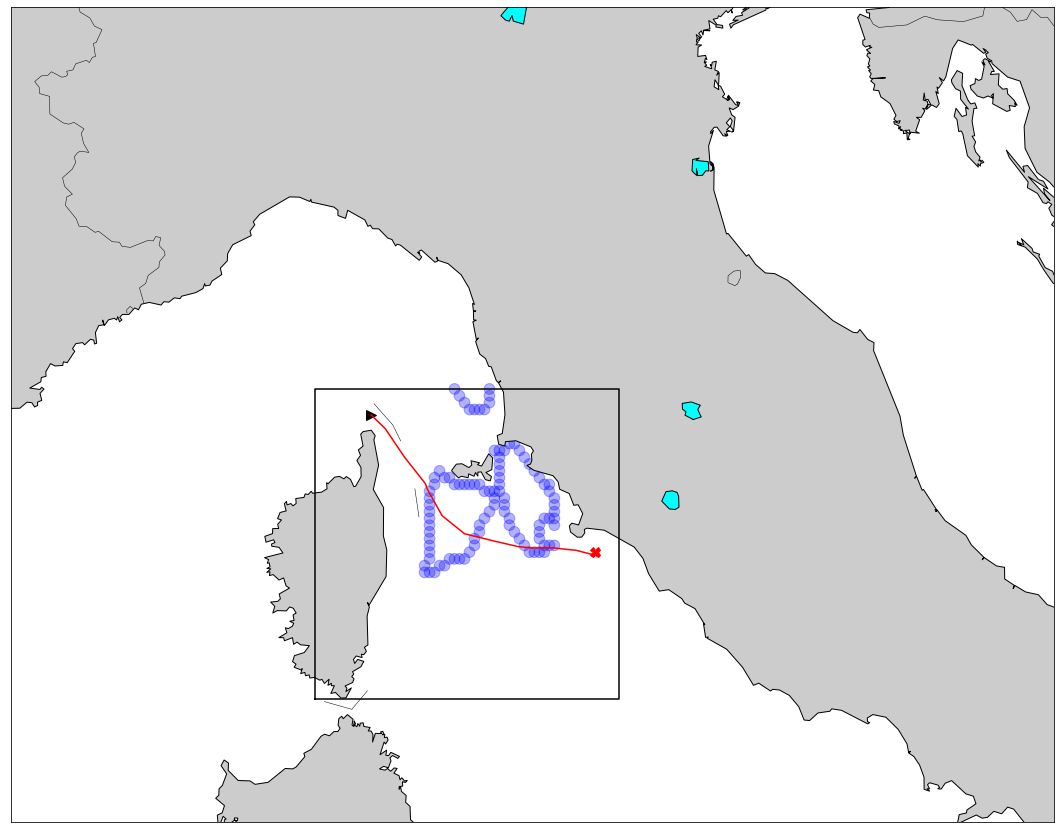

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp = Basemap(projection='merc',
             llcrnrlon=6.42, 
             llcrnrlat=40.58,  
             urcrnrlon=15.13, 
             urcrnrlat=45.5488,  
             resolution='i')
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
for i in range(len(obstacle_list[0])):
    ax.add_patch(plt.Circle(xy=(obstacle_list[0][i][0], obstacle_list[0][i][1]), radius=obstacle_list[0][i][2],
                            color='b', alpha=0.3))
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.plot([x for (x, y) in path_star], [y for (x, y) in path_star], '-r')
mp.fillcontinents(lake_color='aqua')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [114]:
print("The distance to the mission area is " + str(round(cost_tot/1000, 2)) + " km")
sx, sy = mp(9.42857, 43.11295)
gx, gy = mp(11.300001, 42.270832)
print("The 2D distance as the crow flies is: " + str(math.hypot(gx-sx, gy-sy)))

a = (9.42857, 43.11295)
b = (11.300001, 42.270832)
print("The geopy distance as the crow flies is: " + str(geopy.distance.distance(a, b).m))
# from haversine import Unit
# hs.haversine(a,b, unit=Unit.METERS)

The distance to the mission area is 262.08 km
The 2D distance as the crow flies is: 243996.0515623154
The geopy distance as the crow flies is: 226612.81050045145
